# STEP #0: Descrição do Problema
    . Neste projeto, iremos construir, treinar e testar um modelo para classficação de itens fashion utilizando o   
    TensorFlow
    
    . O desafio deste projeto é fazer deploy do modelo final usando o Tensorflow Serving.
    
    . O dataset consiste em 70000 imagens divididas em 60000 para treino e 10000 para teste. As imagens do dataset 
    apresentam um tamanho 28x28 e estão a preto e branco. Todas elas têm um label asssociado.
    
    . Existem 10 classes possiveis:
        . 0 => T-shirt/top
        . 1 => Trouser
        . 2 => Pullover
        . 3 => Dress
        . 4 => Coat
        . 5 => Sandal
        . 6 => Shirt
        . 7 => Sneaker
        . 8 => Bag
        . 9 => Ankel boot
     
     . Nota: O código apresentado de seguida é baseado em código disponibilizado na Documentação do TF serving :
         https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# Step #1: Importar as dependências

In [1]:
import tensorflow as tf
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

#  Step #2: Importar o Dataset

In [2]:
#import Fashion MNIST Dataset using keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# Data Normalization -> Between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
# Reshape training data to be = (6000, 28, 28 , 1)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

In [7]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
# Do the same for the testing dataset
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [9]:
X_test.shape

(10000, 28, 28, 1)

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']

In [11]:
len(X_train)

60000

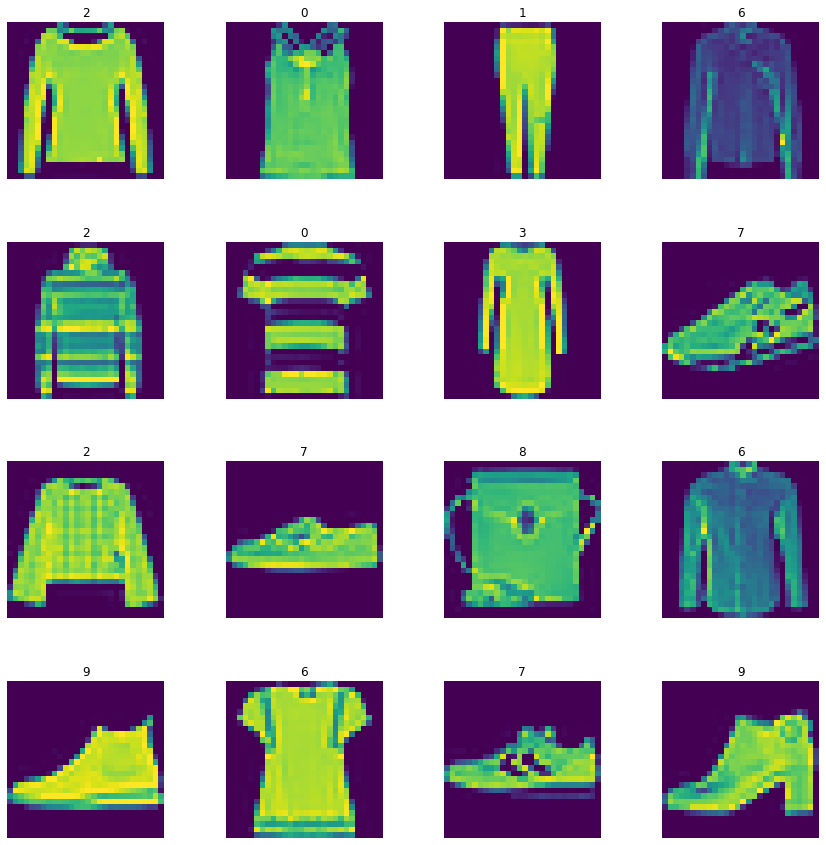

In [12]:
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes= axes.ravel()

n_training = len(X_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index].reshape(28,28))
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

# Step #3: Contruir, treinar e testar o modelo

In [13]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))

cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(64, activation = 'relu'))

cnn.add(tf.keras.layers.Dense(10, activation = 'softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
__________________________________________________

In [14]:
epochs = 5

cnn.compile(optimizer=tf.keras.optimizers.Adam(),
           loss = 'sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [15]:
cnn.fit(X_train, y_train, epochs=epochs)

test_loss, test_acc = cnn.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Epoch 1/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3926 - accuracy: 0.8595
Epoch 2/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2572 - accuracy: 0.9065
Epoch 3/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.2110 - accuracy: 0.9227
Epoch 4/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1744 - accuracy: 0.9352
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 0.2462 - accuracy: 0.9117

Test accuracy: 0.9117000102996826


#  Step #4: Salvar o modelo

    . Para carregar nosso modelo treinado no TensorFlow Serving, primeiro precisamos salvá-lo no formato SavedModel .
    . Isso criará um arquivo protobuf numa hierarquia de diretorias bem definida e incluirá um número de versão. 
    . O TensorFlow Serving permite-nos selecionar qual a versão de um modelo queremos usar ao fazer requests
    . Cada versão será exportada para um subdiretório diferente no caminho fornecido.
    . a função save_model oferece uma forma simples de salvar o nosso modelo:
        . tf.keras.models.save_model(
                                    model, filepath, overwrite=True, include_optimizer=True, save_format=None,
                                    signatures=None, options=None, save_traces=True
                                    )
    . Obtem mais informações em: tensorflow.org/guide/saved_model

In [16]:
#Let´s obtain a temporary storage directory
Model_Directory = tempfile.gettempdir()

In [17]:
Model_Directory

'C:\\Users\\andre\\AppData\\Local\\Temp'

In [18]:
#Let's specify the model version
version = 2.0

In [19]:
#Let´s join the temp model directory with our chosen version number
export_path = os.path.join(Model_Directory, str(version))
print('export_path = {}\n'.format(export_path))

export_path = C:\Users\andre\AppData\Local\Temp\2.0



In [20]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.float64)])
def serving(img):
    #res = tf.io.decode_jpeg(X_test[0], channels=1)
    preprocessed_img = tf.image.resize_with_pad(img, 28, 28) 
    preprocessed_img = tf.image.convert_image_dtype(preprocessed_img, tf.float64) 
    return preprocessed_img

In [21]:
#Let´s save the model using model_save
    
tf.keras.models.save_model(
    cnn,
    export_path,
    overwrite = True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
    )

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\2.0\assets


In [22]:
#Explore MetaGraphDefs and SignatureDefs
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: 

#  Step #5: Servir o Modelo usando TF Serving

## Step 6.1: Adicionar o tensorflow-model-server package à lista de packages

In [9]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

'%sudo' is not recognized as an internal or external command,
operable program or batch file.
'%sudo' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [5]:
%ls -l

 Volume in drive C is TI31320200A
 Volume Serial Number is 3AA0-6C04

 Directory of C:\Users\andre\OneDrive\Área de Trabalho\Análise de Dados



File Not Found
